<a href="https://colab.research.google.com/github/ekolonsky/202208_metahne_lab/blob/main/FEJ_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Experiment with Laser Methane Mini 22-23/08/2022 and 2/09/2022

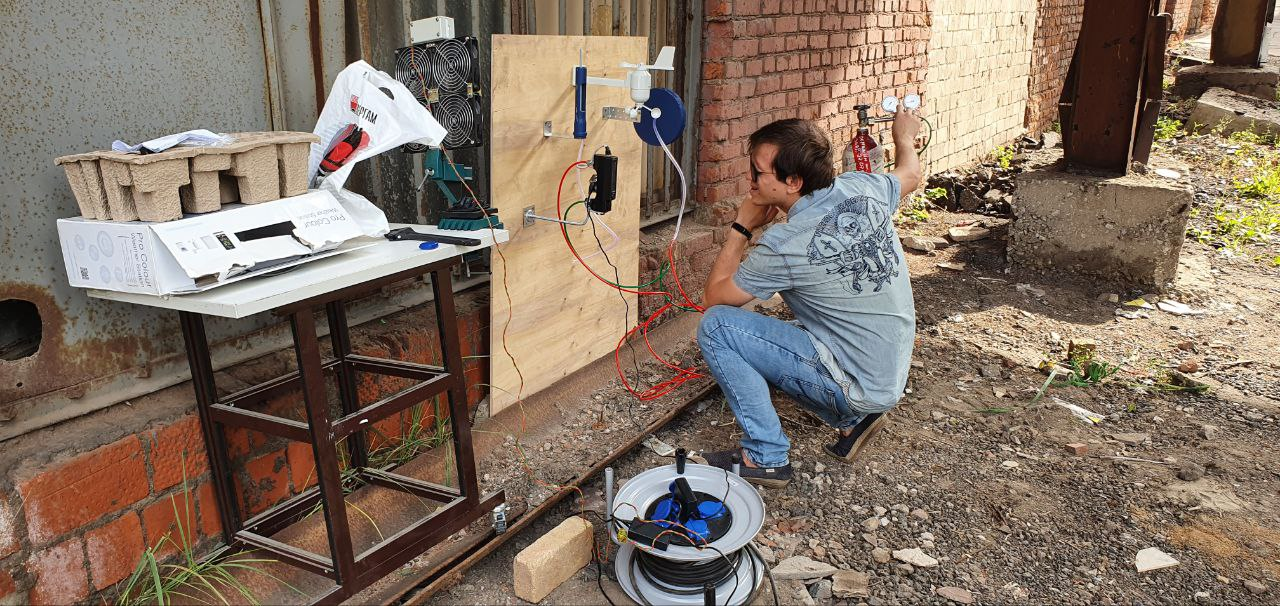

In [ ]:
import pandas as pd
import seaborn as sns

url = 'https://raw.githubusercontent.com/ekolonsky/202208_metahne_lab/main/dataset.txt'
df = pd.read_csv(url,  sep='\t', decimal=',')


In [ ]:
df

,Num,Source,Distance,LR_raw,ppmm_raw,LR
0,1,Valve,15.0,0.0,32,0
1,1,Valve,15.0,0.0,23,0
2,1,Valve,15.0,0.0,68,0
3,1,Valve,15.0,0.0,93,0
4,1,Valve,15.0,0.0,96,0
...,...,...,...,...,...,...
11565,100,Flange,30.0,100.0,50,100
11566,100,Flange,30.0,100.0,14,100
11567,100,Flange,30.0,100.0,170,100
11568,100,Flange,30.0,100.0,199,100


## Сглаживание

In [ ]:
import more_itertools
import numpy as np
def max_mean(values, sliding_window_size=5):
  chunks = list(more_itertools.windowed(values, sliding_window_size))
  means = list(map(np.mean, chunks))
  return np.max(means)

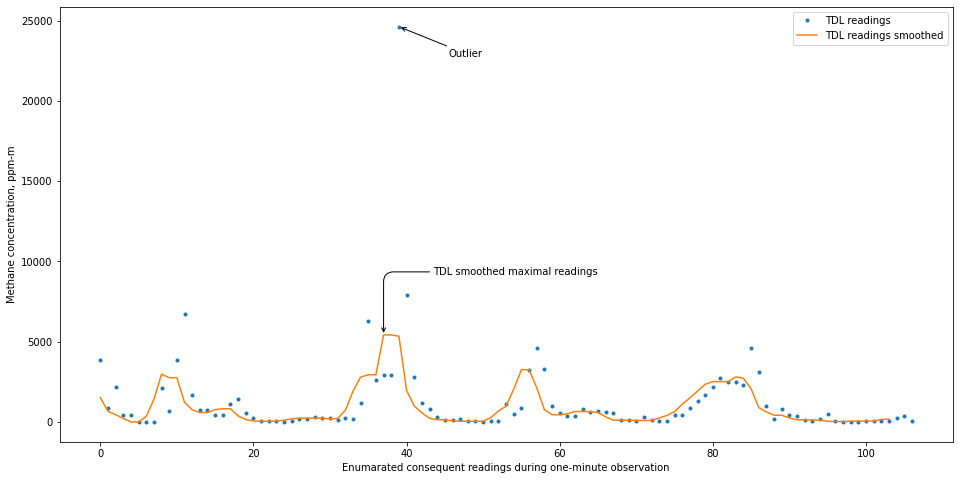

In [ ]:
import matplotlib.pyplot as plt
width=4
Num=27 # observation Num
ppms = list(df[df.Num==Num]['ppmm_raw'])[width//2:-width//2]
smooth = list(map(np.median,list(more_itertools.windowed(ppms, width)))) 


fig, ax = plt.subplots(figsize=(16, 8))


ax.plot(ppms, '.', label='TDL readings')
outliery = max(ppms)
outlierx = ppms.index(outliery)
ax.annotate('Outlier', xy=(outlierx, outliery), xycoords='data',
    xytext=(50, -30), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

ax.plot(smooth, label='TDL readings smoothed')
smoothy = max(smooth)
smoothx = smooth.index(smoothy)
ax.annotate('TDL smoothed maximal readings', xy=(smoothx, smoothy), xycoords='data',
    xytext=(50, 60), textcoords='offset points',
    arrowprops=dict(arrowstyle="->",
                    connectionstyle="angle,angleA=0,angleB=90,rad=10"))

ax.set_ylabel('Methane concentration, ppm-m')
ax.set_xlabel('Enumarated consequent readings during one-minute observation')
ax.legend()

In [ ]:
records = []
for num in df.Num.unique():
  ppms = df[df.Num==num]['ppmm_raw']
  maxmean = max_mean(ppms,4)
  LR = df[df.Num==num]['LR'].unique()[0]
  D = df[df.Num==num]['Distance'].unique()[0]
  VF = df[df.Num==num]['Source'].unique()[0]
  record = [LR, D, VF, maxmean]
  records.append(record)
data = pd.DataFrame(records, columns = ['LeakRate', 'Distance','Source', 'ppmm'])
data['zero_leak'] = data.LeakRate ==0


In [ ]:
data

,LeakRate,Distance,Source,ppmm,zero_leak
0,0,15.0,Valve,127.50,True
1,3,10.0,Valve,106.75,False
2,3,15.0,Valve,113.00,False
3,6,10.0,Valve,163.25,False
4,6,15.0,Valve,128.00,False
...,...,...,...,...,...
90,100,12.0,Flange,2580.75,False
91,100,15.0,Flange,956.75,False
92,100,20.0,Flange,857.50,False
93,100,25.0,Flange,626.00,False


Text(0, 0.5, 'TDL readings, ppm × m')

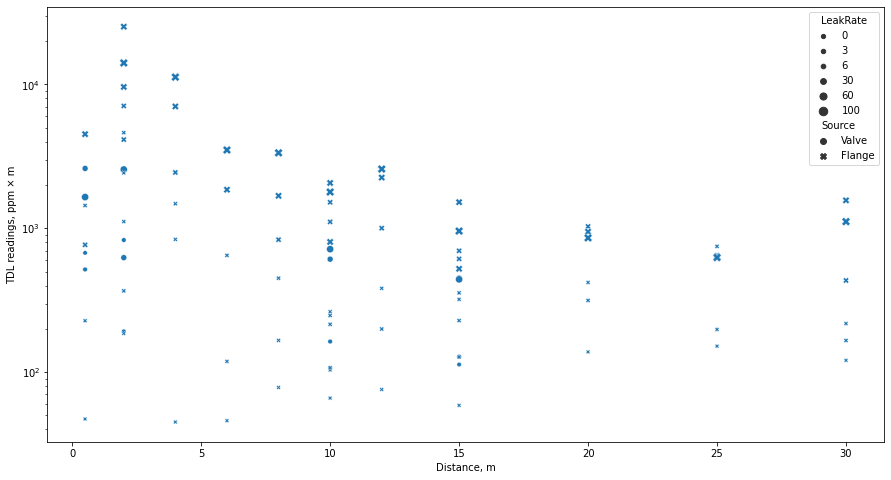

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,8))
plt.yscale('log')
g  = sns.scatterplot(data=data, x="Distance", y="ppmm", style='Source', size='LeakRate')
plt.xlabel("Distance, m")
plt.ylabel("TDL readings, ppm × m")


In [ ]:
ppm_zeroleak = data[data.zero_leak]['ppmm'].max()
ppm_leak = ppm_zeroleak
for lrt in [0, 3, 6, 30, 60]:
  y = data[data.LeakRate == lrt]['ppmm'].min()
  print(lrt, y)
  if ppm_leak < y:
    ppm_leak = y
print(ppm_zeroleak, ppm_leak, (ppm_leak + ppm_zeroleak)/2)

0 45.0
3 106.75
6 128.0
30 433.75
60 441.25
185.75 441.25 313.5


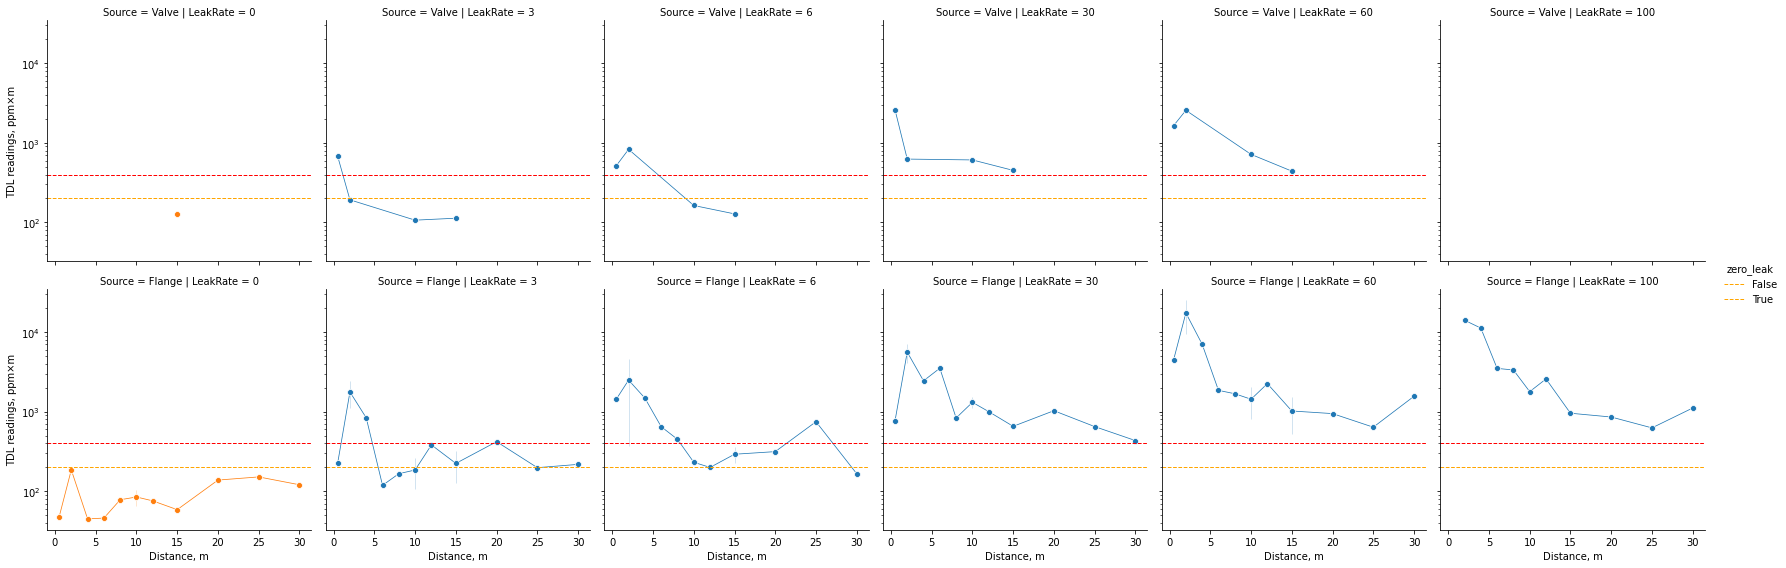

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

g = sns.FacetGrid(data, row='Source', col='LeakRate', hue='zero_leak',  height=4)
g.map_dataframe(sns.lineplot,  "Distance", "ppmm", marker='o', size=100)
g.set_axis_labels("Distance, m", "TDL readings, ppm×m").set(yscale = 'log')
g.refline(y = 400, color = "red", lw = 1)
g.refline(y = 200, color = "orange", lw = 1)
g.add_legend()

In [ ]:
data['Leak ≥ 30 g/h'] =  data.LeakRate >= 30 

In [ ]:
filter_method = lambda x: '30 g/h and over' if x >= 30 else '3 - 6 g/h' if (x > 0 and x < 30) else 'No emission' if x == 0 else None
data['Leaks'] = data['LeakRate'].apply(filter_method)
data

,LeakRate,Distance,Source,ppmm,zero_leak,Leak ≥ 30g/h,Leak ≥ 30 g/h,Leak category,"Leak, g/h",Leaks
0,0,15.0,Valve,127.50,True,False,False,No emission,No emission,No emission
1,3,10.0,Valve,106.75,False,False,False,0 < Leak < 30 g/h,0< leak <30,3 - 6 g/h
2,3,15.0,Valve,113.00,False,False,False,0 < Leak < 30 g/h,0< leak <30,3 - 6 g/h
3,6,10.0,Valve,163.25,False,False,False,0 < Leak < 30 g/h,0< leak <30,3 - 6 g/h
4,6,15.0,Valve,128.00,False,False,False,0 < Leak < 30 g/h,0< leak <30,3 - 6 g/h
...,...,...,...,...,...,...,...,...,...,...
90,100,12.0,Flange,2580.75,False,True,True,Leak ≥ 30 g/h,leak ≥ 30,30 g/h and over
91,100,15.0,Flange,956.75,False,True,True,Leak ≥ 30 g/h,leak ≥ 30,30 g/h and over
92,100,20.0,Flange,857.50,False,True,True,Leak ≥ 30 g/h,leak ≥ 30,30 g/h and over
93,100,25.0,Flange,626.00,False,True,True,Leak ≥ 30 g/h,leak ≥ 30,30 g/h and over


Text(17, -50, 'No emission threshold')

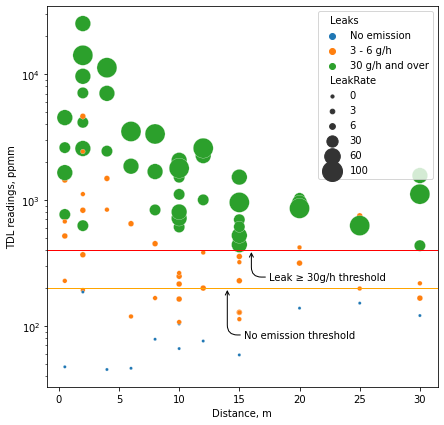

In [ ]:
f, ax = plt.subplots(figsize=(7, 7))
ax = sns.scatterplot(data=data, x="Distance", y="ppmm", hue='Leaks', 
                     hue_order = ['No emission', '3 - 6 g/h', '30 g/h and over'], size='LeakRate', sizes=(10, 400))
ax.set(yscale="log")
#g.set("Distance, m", "RMLD readings, ppmm").set(yscale = 'log')
plt.xlabel('Distance, m')
plt.ylabel('TDL readings, ppmm')
ax.axhline(400, color = "red", lw = 1, label='400 ppm×m')

ax.annotate('Leak ≥ 30g/h threshold', xy=(16, 400), xycoords='data',
    xytext=(18, -30), textcoords='offset points',
    arrowprops=dict(arrowstyle="->",
                    connectionstyle="angle,angleA=0,angleB=90,rad=10"))


ax.axhline(200, color = "orange", lw = 1, label='200 ppm×m')

ax.annotate('No emission threshold', xy=(14, 200), xycoords='data',
    xytext=(17, -50), textcoords='offset points',
    arrowprops=dict(arrowstyle="->",
                    connectionstyle="angle,angleA=0,angleB=-90,rad=10"))

In [ ]:
def accuracy(RDML_treshold, LR_treshold, Distance_max=50):
  TN, TP, FN, FP = 0,0,0,0
  for index, row in data.iterrows():
    distance = row['Distance']
    ppmm = row['ppmm']
    LR = row['LeakRate']
    if distance > Distance_max:
      continue
    actual = LR >= LR_treshold
    predictor = ppmm >= RDML_treshold
    if actual and predictor:
      TP += 1
    if actual and not predictor:
      FN += 1
    if not actual and predictor:
      FP += 1
    if not actual and not predictor:
      TN += 1
  precision = TP / (TP + FP)
  recall = TP / (TP + FN)
  return precision, recall
      

In [ ]:
accuracy(300, 30)

(0.71875, 1.0)

In [ ]:
def find_ppmm_threshold(lrt, dist):
  P_max = 0
  ppmt_optimal = 0
  for ppmt in [200, 250, 300, 350, 400, 450, 500, 550, 600]:
    P, R = accuracy(ppmt, lrt, dist)
    if R < 1:  # recall should be not less 1
      continue   
    if P_max < P:
      ppmt_optimal = ppmt
      P_max = P
  return P_max, ppmt_optimal
find_ppmm_threshold(30, 15)

(0.7708333333333334, 400)

In [ ]:
for lrt in [3, 6, 30, 60]:
  for d in [5, 10, 15, 20, 25, 30]:
    print(lrt, d, find_ppmm_threshold(lrt, d))

3 5 (0, 0)
3 10 (0, 0)
3 15 (0, 0)
3 20 (0, 0)
3 25 (0, 0)
3 30 (0, 0)
6 5 (0.8333333333333334, 250)
6 10 (0, 0)
6 15 (0, 0)
6 20 (0, 0)
6 25 (0, 0)
6 30 (0, 0)
30 5 (0.6363636363636364, 550)
30 10 (0.75, 550)
30 15 (0.7708333333333334, 400)
30 20 (0.7692307692307693, 400)
30 25 (0.7678571428571429, 400)
30 30 (0.7796610169491526, 400)
60 5 (0.36363636363636365, 550)
60 10 (0.4444444444444444, 550)
60 15 (0.4583333333333333, 400)
60 20 (0.46153846153846156, 400)
60 25 (0.4642857142857143, 400)
60 30 (0.4745762711864407, 400)


## Result #1: threshold 250 ppmm at distances up to 5m for leak definition threshold 6 g/h
## Result #2: threshold 400 ppmm at distances up to 30m for leak definition threshold 30 g/h